In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

import jax
import jax.numpy as np
import jax.scipy as jsp
from jax.scipy.stats import poisson
jax.config.update("jax_enable_x64", True)

import dLux as dl
import dLux.utils as dlu
import dLuxWebbpsf as dlw

import optax
import zodiax as zdx
from zodiax.experimental import serialise, deserialise

from polybfe import PolyBFE, AmplifierNoise
import ehtplot

from astropy.io import fits
import astropy.units as u

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import colormaps
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

# Loading in Io data
let's

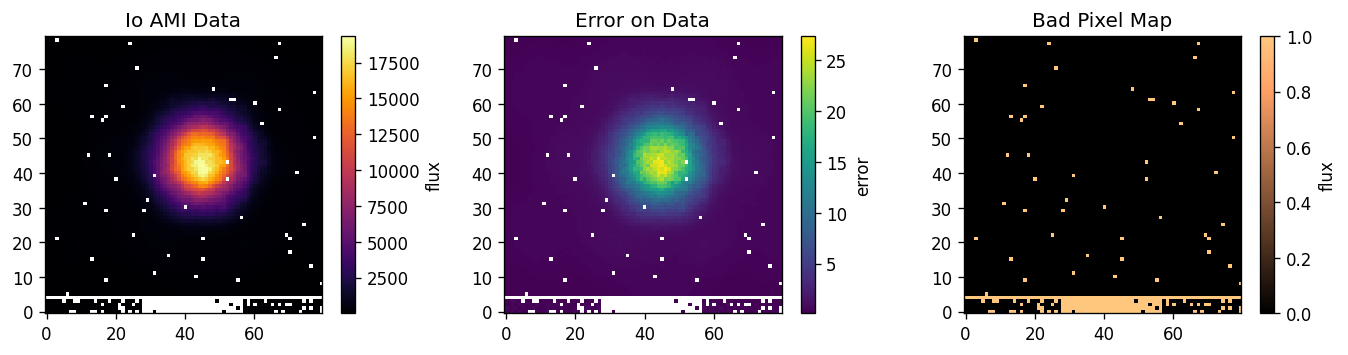

In [2]:
data_dir = "/Users/mcha5804/JWST/ERS1373/"
files = [
    # "jw01373017001_02101_00001_nis_cal.fits",
    # "jw01373017001_02101_00002_nis_cal.fits",
    # "jw01373017001_02101_00003_nis_cal.fits",
    # "jw01373017001_02101_00004_nis_cal.fits",
    "jw01373017001_04102_00001_nis_cal.fits",
    # "jw01373017001_04102_00002_nis_cal.fits",
    # "jw01373017001_04102_00003_nis_cal.fits",
    # "jw01373017001_04102_00004_nis_cal.fits",
    # "jw01373017001_04102_00005_nis_cal.fits",
]

hdu = fits.open(data_dir + files[0])

data_array = np.array(hdu['SCI'].data)

# Creating bad pixel mask
# n = 5  # number of edge pixels to clip
# clip_mask = ~np.pad(np.ones(shape=(data_array.shape[0]-2*n, data_array.shape[1]-2*n), dtype=bool), n)
clip_mask = data_array < 0.
nan_mask = np.isnan(data_array)  # nan mask
bad_mask = nan_mask | clip_mask
data = data_array.at[bad_mask].set(np.nan)
err = np.array(hdu['ERR'].data).at[bad_mask].set(np.nan)

# data = np.nan_to_num(np.array(hdu['SCI'].data), nan=0.0)

# plotting
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
c1 = ax[0].imshow(data, cmap="inferno")
fig.colorbar(c1, label="flux")
ax[0].set(
    title="Io AMI Data"
)
c2 = ax[1].imshow(err, cmap="viridis")
fig.colorbar(c2, label="error")
ax[1].set(
    title="Error on Data"
)

c3 = ax[2].imshow(bad_mask, cmap="copper")
fig.colorbar(c3, label="flux")
ax[2].set(
    title="Bad Pixel Map"
)
plt.show()

# Deserialising the model
We want to load in the model of the calibrator star and use it as our point spread function. However, some things will be different.

The amplifier noise will not be common between science and calibrator targets, so we will set this to zero.

In [3]:
model_dir = "/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/desdoigts/bfe/files/models/"
model_str = "PSFCAL.2022A-HD2236-K6_F430M_023_02.zdx"

telescope = deserialise(model_dir + model_str)

# Killing 1/f noise
telescope = telescope.set(
    'detector.OneOnF.coeffs',
    np.zeros(shape=telescope.detector.OneOnF.coeffs.shape),
)

## Model

Angular Size of Io: 1.1519 arcseconds, 17.5793 pixels


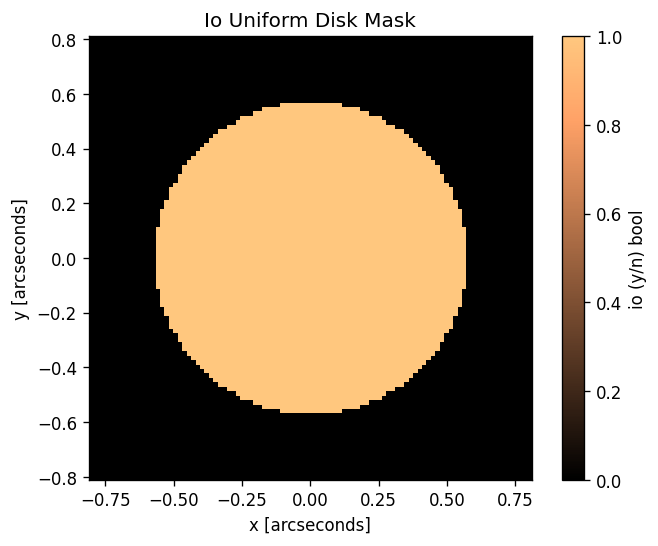

In [4]:
npix = 100
io_initial_distance = 4.36097781166671 * u.AU
io_final_distance = 4.36088492436330 * u.AU
io_diameter = 3643.2 * u.km  # from wikipedia

io_mean_distance = (io_initial_distance + io_final_distance).to(u.km) / 2
angular_size = dlu.rad2arcsec(io_diameter / io_mean_distance)  # angular size in arcseconds

print(f"Angular Size of Io: {angular_size:.4f} arcseconds, {angular_size / telescope.psf_pixel_scale:.4f} pixels")

coords = dlu.pixel_coords(npixels=npix, diameter=npix * telescope.psf_pixel_scale / telescope.oversample)
io = dlu.circle(coords, radius=angular_size/2)

fig, ax = plt.subplots()
im = ax.imshow(
    io,
    extent=[coords.min(), coords.max(), coords.min(), coords.max()],
    cmap='copper',
    )
ax.set(
    title="Io Uniform Disk Mask",
    xlabel="x [arcseconds]",
    ylabel="y [arcseconds]",
)
plt.colorbar(im, label="io (y/n) bool")
plt.show()


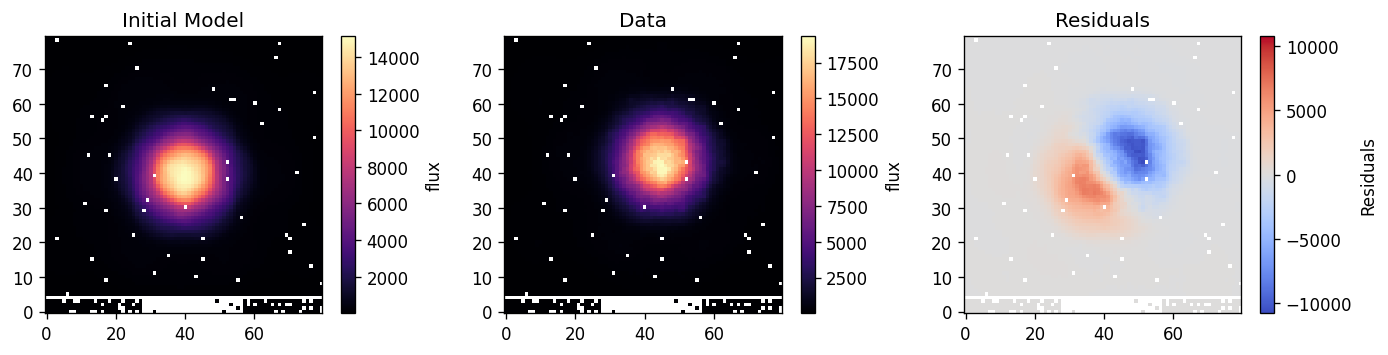

In [5]:
model = telescope.set(
    'source', 
    dl.ResolvedSource(
        wavelengths=telescope.source.wavelengths, # TODO mess with spectrum
        # position=dlu.arcsec2rad(np.array([0.33, -0.25])),
        flux=5e7,
        distribution=io
        # distribution=np.ones(
        #     (telescope.psf_npixels*telescope.oversample, telescope.psf_npixels*telescope.oversample)
        #     )
        # weights=telescope.source.weights,
        )
    )

fig, ax = plt.subplots(1, 3, figsize=(14, 3))
c1 = ax[0].imshow(np.where(bad_mask, np.nan, model.model()), cmap="magma")
fig.colorbar(c1, label="flux")
ax[0].set(
    title="Initial Model"
)

c2 = ax[1].imshow(data, cmap="magma")
fig.colorbar(c2, label="flux")
ax[1].set(
    title="Data"
)

resid = model.model() - data
ext = np.array([np.nanmax(resid), -np.nanmin(resid)]).max()
c3 = ax[2].imshow(resid, cmap="coolwarm", vmin=-ext, vmax=ext)
fig.colorbar(c3, label="Residuals")
ax[2].set(
    title="Residuals"
)
plt.show()

# plt.imshow(model.source.distribution, cmap='afmhot_10u')
# plt.colorbar()
# plt.title("Model Source Distribution")
# plt.show()


## Regularisation

In [6]:
def ent(array, eps=1e-10):
    """calcualtes the entropy of the array"""
    return -np.nansum(array * np.log(array + eps))

def total_variation(array):
    """calcualtes the total variation of the array"""
    array = np.pad(array, 2)
    diff_y = np.nansum(np.abs(array[1:, :] - array[:-1, :]))
    diff_x = np.nansum(np.abs(array[:, 1:] - array[:, :-1]))
    return diff_x + diff_y

def quadratic_variation(array):
    """calcualtes the quadratic variation of the array"""
    array = np.pad(array, 2)
    diff_y = np.nansum(np.square(array[1:, :] - array[:-1, :]))
    diff_x = np.nansum(np.square(array[:, 1:] - array[:, :-1]))
    return diff_x + diff_y

In [7]:
params = [
    'flux',
    'position',
    'distribution',
]

def loglike_loss(model, data):
    # model = model.set('source.distribution', np.abs(model.get('source.distribution')))
    model_array = np.where(bad_mask, np.nan, model.model())
    return -np.nansum(poisson.logpmf(data, model_array))

def entropy_loss(model):
    return -ent(model.get(params))

def total_variation_loss(model):
    return total_variation(model.get(params))

def quadratic_variation_loss(model):
    return quadratic_variation(model.get(params))

In [8]:
@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn(model, data):#, alpha=0, beta=0, gamma=0):
    poisson_loss = loglike_loss(model, data)
    # entropy = alpha * entropy_loss(model)
    # total_variation = beta * total_variation_loss(model)
    # quadratic_varition = gamma * quadratic_variation_loss(model)
    return poisson_loss # + entropy + total_variation + quadratic_varition


# def loss_fn(model, data, err):
#     print(np.nansum(data), np.nansum(err))
#     return - jsp.stats.norm.logpdf(model.model(), loc=data, scale=err).mean()

In [9]:
%%time
loss, grads = loss_fn(model, data)
print("Initial Loss: {:.3e}".format(loss))

Initial Loss: 2.426e+06
CPU times: user 13 s, sys: 663 ms, total: 13.7 s
Wall time: 5.62 s


## Gradient Descent

In [10]:
iters = 100

delay = lambda lr, s: optax.piecewise_constant_schedule(lr * 1e-16, {s:1e16})
optimisers = [
    optax.adam(5e5),  # flux
    # optax.adam(optax.piecewise_constant_schedule(5e5 * 1e-16, {0.25*iters:1e16})),  # flux
    optax.adam(optax.piecewise_constant_schedule(5e-8, {0.5*iters:1e-16})),  # position
    optax.adam(optax.piecewise_constant_schedule(1e-5 * 1e-16, {0.5*iters:1e16})),  # dist
]

optim, opt_state = zdx.get_optimiser(model, params, optimisers)
losses, fluxes, poses, models_out = [], [], [], [model]

with tqdm(range(iters),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, data)
        updates, opt_state = optim.update(grads, opt_state)
    
        model = zdx.apply_updates(model, updates)
        if i == iters-1:
            models_out.append(model)

        losses.append(loss)
        fluxes.append(model.get('flux'))
        poses.append(model.get('position'))

        t.set_description("Loss: {:.8e}".format(loss.mean())) # update the progress bar

Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
losses = np.array(losses)
fluxes = np.array(fluxes)
poses = np.array(poses)

final_model = models_out[-1]
# model_resids = (models_out - data).reshape(models_out.shape[0], -1)


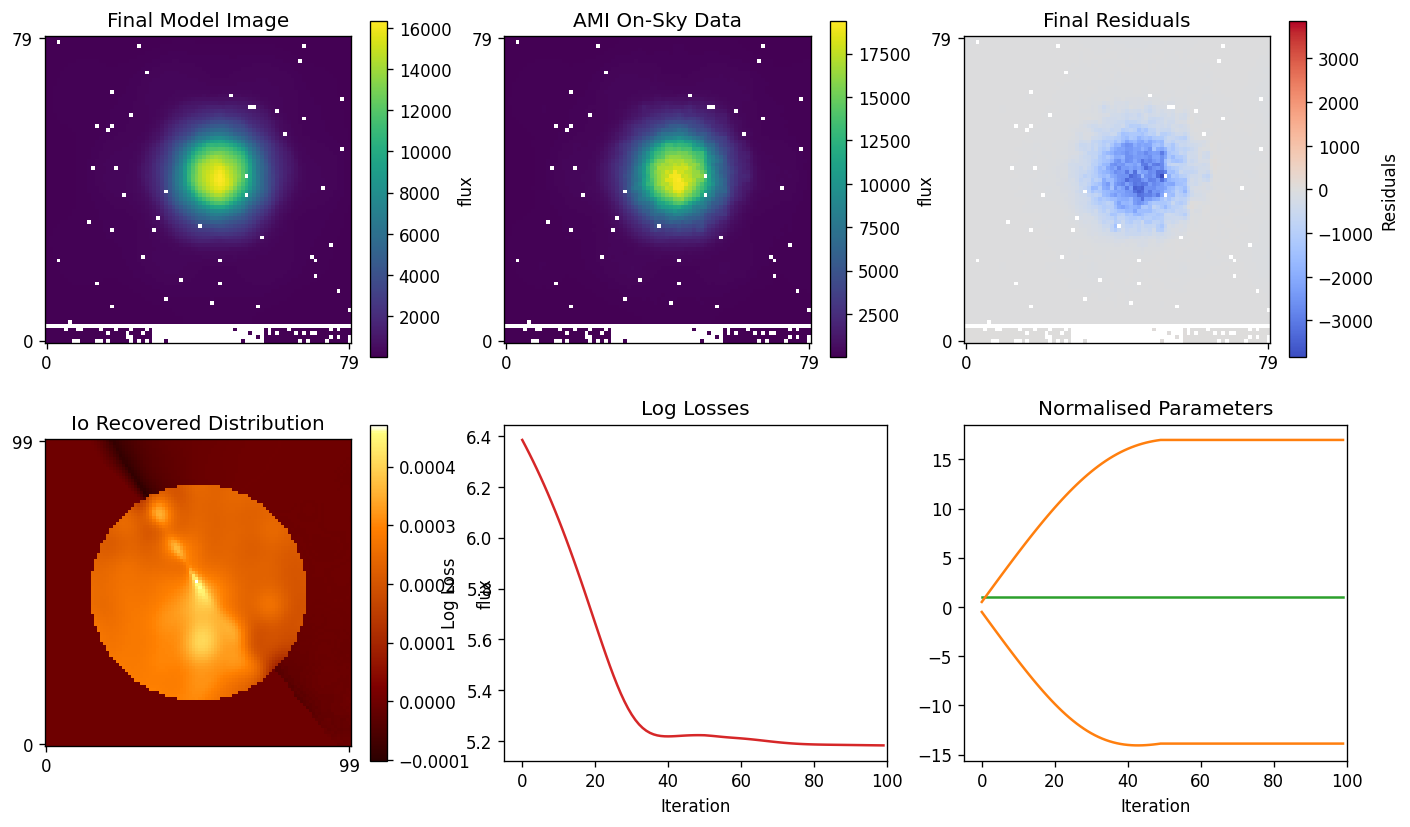

In [12]:
final_model_image = final_model.model()

fig, ax = plt.subplots(2, 3, figsize=(14, 8))
c1 = ax[0][0].imshow(np.where(bad_mask, np.nan, final_model_image), cmap="viridis")
fig.colorbar(c1, label="flux")
ax[0][0].set(
    title="Final Model Image",
    xticks=[0, final_model_image.shape[0]-1],
    yticks=[0, final_model_image.shape[1]-1],
)

c2 = ax[0][1].imshow(data, cmap="viridis")
fig.colorbar(c2, label="flux")
ax[0][1].set(
    title="AMI On-Sky Data",
    xticks=[0, data.shape[0]-1],
    yticks=[0, data.shape[1]-1],
)

resid = final_model_image - data
ext = np.array([np.nanmax(resid), -np.nanmin(resid)]).max()
c3 = ax[0][2].imshow(resid, cmap="coolwarm", vmin=-ext, vmax=ext)
fig.colorbar(c3, label="Residuals")
ax[0][2].set(
    title="Final Residuals",
    xticks=[0, resid.shape[0]-1],
    yticks=[0, resid.shape[1]-1],
)

# source distribution
c4 = ax[1][0].imshow(final_model.source.distribution, cmap="afmhot_10u")
fig.colorbar(c4, label="flux")
ax[1][0].set(
    title="Io Recovered Distribution",
    xticks=[0, final_model.source.distribution.shape[0]-1],
    yticks=[0, final_model.source.distribution.shape[1]-1],
)

# Fifth plot taking up the space of bottom middle and bottom right plot
ax[1][1].plot(np.log10(losses), c="tab:red")
ax[1][1].set(
    title="Log Losses",
    xlabel="Iteration",
    ylabel="Log Loss",
    xlim=[None, iters],
)

ax[1][2].plot(fluxes/fluxes.mean(), c="tab:green", label="flux")
ax[1][2].plot(poses/poses.mean(), c="tab:orange", label="position")
ax[1][2].set(
    title="Normalised Parameters",
    xlabel="Iteration",
    xlim=[None, iters],
)
# plt.savefig('io.pdf', bbox_inches='tight')
plt.show()

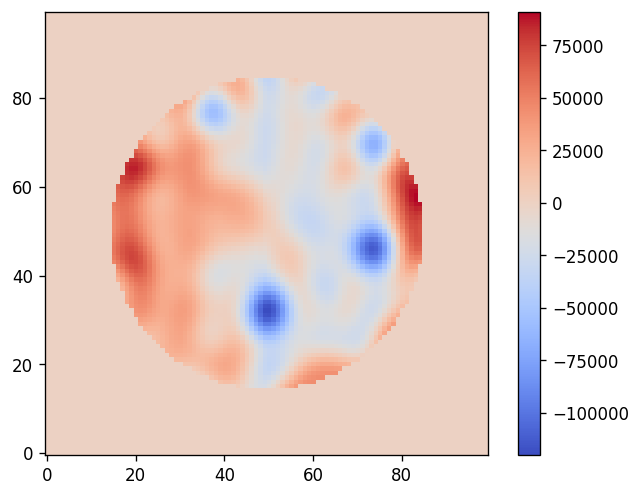

In [13]:
plt.imshow(grads.distribution, cmap='coolwarm')
plt.colorbar()

In [14]:
final_model.flux

50000000.0